In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.interpolate import lagrange

from statsmodels.tsa.stattools import adfuller #ADF检验
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #画图定阶
from statsmodels.tsa.arima_model import ARIMA #模型
from statsmodels.tsa.arima_model import ARMA #模型
from statsmodels.stats.stattools import durbin_watson #DW检验
from statsmodels.graphics.api import qqplot #qq图

from sklearn.model_selection import train_test_split #划分数据集


plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
data = pd.read_excel(r'F:\I_love_learning\junior\数据挖掘与数据仓库\课程设计\dataroom2.xlsx')
data

,Unnamed: 0,Unnamed: 0.1,房名,总价,单价,户型,朝向,面积,小区名称,所在区域,挂牌时间
0,0,0,此房私产满5唯一，视野采光无遮挡，产权明晰无纠纷,509.0,62439,2室1厅,南,81.52,金德园,和平 南营门街 内环至中环,2021-03-06
1,1,1,云台花园 次新房 双阳两居室 私产好楼层 有钥匙,408.0,54714,2室1厅,南,74.57,云台花园,和平 劝业场,2021-03-05
2,2,2,经典两室 不带角的好户型 中高楼层 采光无遮挡,609.0,68900,2室1厅,南,88.39,金德园,和平 南营门街 内环至中环,2021-02-22
3,3,3,兴润公寓阳面婚房两居 教玉用房 视野无遮挡 采光好,405.0,57358,2室1厅,南,70.61,兴润公寓,和平 南营门街 内环至中环,2019-12-20
4,4,4,融创星美御精装修，地采暖，24小时管家式服务社区,480.0,58824,2室1厅,南 北,81.60,融创星美御,和平 新兴街,2020-04-20
...,...,...,...,...,...,...,...,...,...,...,...
41212,41212,41212,建泰楼 3室2厅 南,61.0,6162,3室2厅,南,99.00,建泰楼,静海 静海,2021-02-25
41213,41213,41213,梧桐公社 3室1厅 南 北,239.0,24132,3室1厅,南 北,99.04,梧桐公社,静海 团泊西 远郊县区,2021-02-19
41214,41214,41214,位置优越 房主诚售 价格可议 环境也好,240.0,14429,5室3厅,南 北,166.34,湖语公园,静海 团泊东 远郊县区,2021-01-21
41215,41215,41215,金地长湖湾 5室2厅 南 北,210.0,13381,5室2厅,南 北,156.94,金地长湖湾,静海 团泊东 外环外,2021-01-24


In [3]:
#X_train , X_test , y_train,y_test = train_test_split(data_day.index,data_day['单价'],test_size=0.25,random_state=0)


In [4]:
#data_train = pd.DataFrame(y_train)
#data_test = pd.DataFrame(y_test)
#data_train

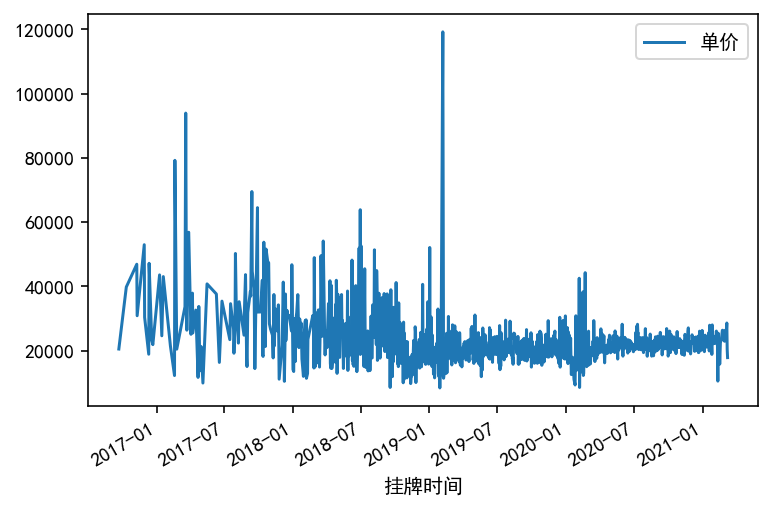

In [5]:

data_ana = data[['单价','挂牌时间']].groupby(by = '挂牌时间').mean()
data_ana.sort_index(inplace = True)
#data_ana = data_ana[data_ana.index >datetime.datetime(2019,12,1)]
data_ana.plot()
plt.show()

In [6]:
data_per = data_ana[data_ana.index >= datetime.datetime(2020,1,1)]
data_per.reset_index(inplace = True)
data_per

,挂牌时间,单价
0,2020-01-01,18060.117647
1,2020-01-02,19228.615385
2,2020-01-03,24001.875000
3,2020-01-04,21953.129032
4,2020-01-05,27163.600000
...,...,...
426,2021-03-05,26101.822222
427,2021-03-06,26492.209677
428,2021-03-07,28569.045455
429,2021-03-08,20387.647059


In [7]:
#选取一月到三月的值
date_se = pd.DataFrame({'time':pd.date_range('2020/3/6','2021/3/7')})
date_se

,time
0,2020-03-06
1,2020-03-07
2,2020-03-08
3,2020-03-09
4,2020-03-10
...,...
362,2021-03-03
363,2021-03-04
364,2021-03-05
365,2021-03-06


In [8]:
#外连接之后拉格朗日填补缺失值

data_day = pd.merge(date_se,data_per,left_on ='time',right_on = '挂牌时间',how = 'outer')
del data_day['挂牌时间']
def na_c(s,n,k=5):
    y = s.reindex(list(range(n-k, n)) + list(range(n+1, n+1+k))) #取数不报错代码段
    y = y[y.notnull()]  # 剔除空值
    return(lagrange(y.index,list(y))(n))
# 创建函数，做插值，由于数据量原因，以空值前后5个数据（共10个数据）为例做插值

na_re = []
for i in range(len(data_day['单价'])):
    if data_day['单价'].isnull()[i]:
        data_day['单价'][i] = na_c(data_day['单价'],i)
        print(na_c(data_day['单价'],i))
        na_re.append(data_day['单价'][i])
data_day = data_day.dropna()
data_day

,time,单价
0,2020-03-06,15905.642857
1,2020-03-07,15837.480000
2,2020-03-08,19335.333333
3,2020-03-09,20660.233333
4,2020-03-10,20979.240000
...,...,...
362,2021-03-03,26292.367442
363,2021-03-04,26393.600000
364,2021-03-05,26101.822222
365,2021-03-06,26492.209677


In [9]:
data_day.set_index('time',inplace = True)
data_day

,单价
time,
2020-03-06,15905.642857
2020-03-07,15837.480000
2020-03-08,19335.333333
2020-03-09,20660.233333
2020-03-10,20979.240000
...,...
2021-03-03,26292.367442
2021-03-04,26393.600000
2021-03-05,26101.822222


In [10]:
data_train = data_day['2020/3/6':'2021/3/5']
data_test = data_day['2021/3/6':'2021/3/7']
data_test

,单价
time,
2021-03-06,26492.209677
2021-03-07,28569.045455


In [11]:
data_train.head()

,单价
time,
2020-03-06,15905.642857
2020-03-07,15837.480000
2020-03-08,19335.333333
2020-03-09,20660.233333
2020-03-10,20979.240000


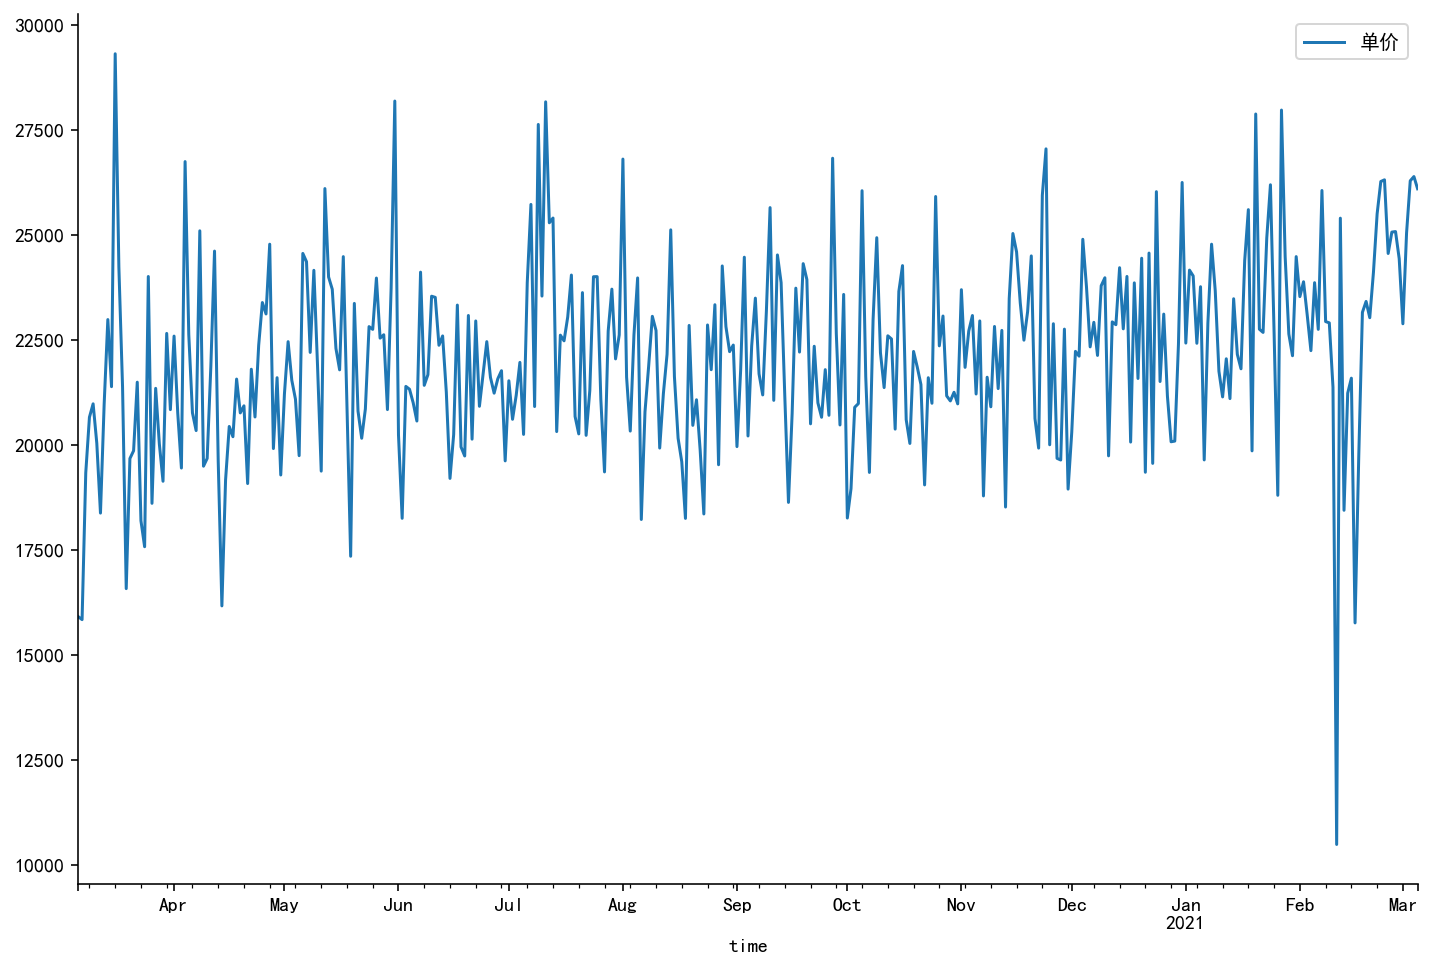

In [12]:
data_train.plot(figsize = (12,8))
sns.despine()

In [13]:
def stationarity(timeseries): #平稳性处理：差分法
    #差分法(不平稳处理),保存成新的列,1阶差分,dropna() 删除缺失值
    diff1 = timeseries.diff(1).dropna() 
    diff2 = diff1.diff(1) #在一阶查分基础上做二阶查分
    
    diff1.plot(color = 'red',title='diff 1',figsize=(10,4))
    diff2.plot(color = 'black',title='diff 2',figsize=(10,4))
    #滚动平均（平滑法不平稳处理）
    rolmean = timeseries.rolling(window=4,center = False).mean()
    #滚动标准差
    rolstd = timeseries.rolling(window=4,center = False).std()
    
 
    rolmean.plot(color = 'yellow',title='Rolling Mean',figsize=(10,4))
    rolstd.plot(color = 'blue',title='Rolling Std',figsize=(10,4))

    #ADF检验 
    x = np.array(diff1['单价'])
    adftest = adfuller(x, autolag='AIC')
    print (adftest)
    #白噪声检验
    p_value = acorr_ljungbox(timeseries, lags=1) 
    print (p_value)

(-8.326629955332983, 3.456538369051781e-13, 14, 349, {'1%': -3.449226932880019, '5%': -2.869857365438656, '10%': -2.571201085130664}, 6327.210685442877)
(array([10.56127914]), array([0.00115481]))


F:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


'\nADT检验\n (1) 1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设，本数据中，adf结果为-6.9， 小于三个level的统计值。\n\n（2）P-value是否非常接近0.本数据中，P-value 为 6.21e-23，接近0。\nADT检验结果说明数据平稳\n\n非白噪声检验\n\n统计量的P值约为0.0085，小于显著性水平0.05，则可以以95%的置信水平拒绝原假设，认为序列为非白噪声序列（否则，接受原假设，认为序列为纯随机序列。）  \n\n'

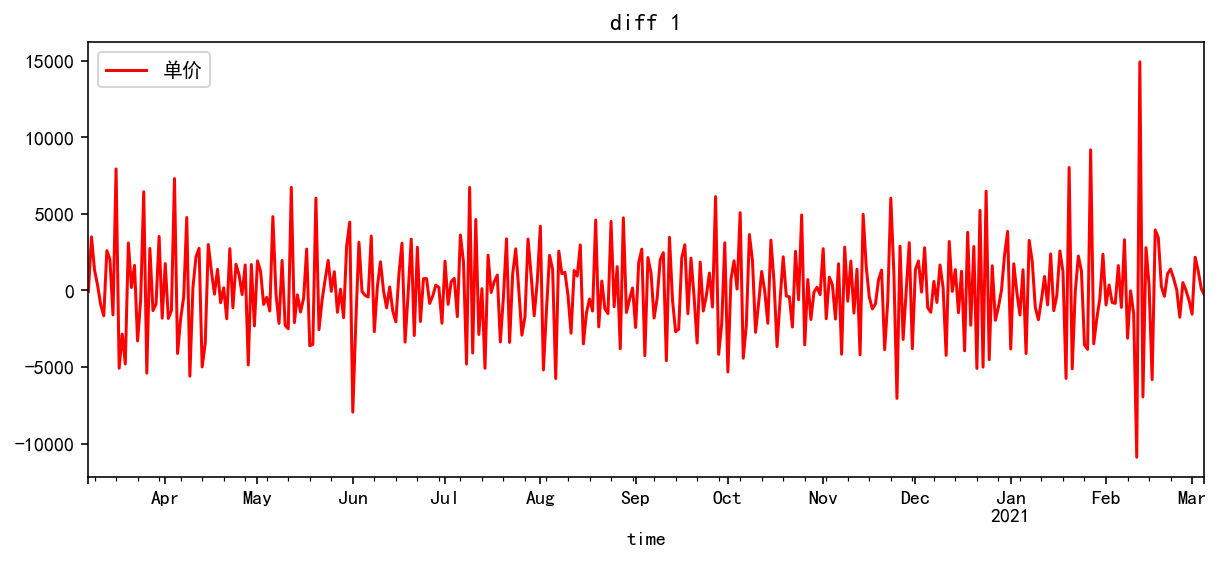

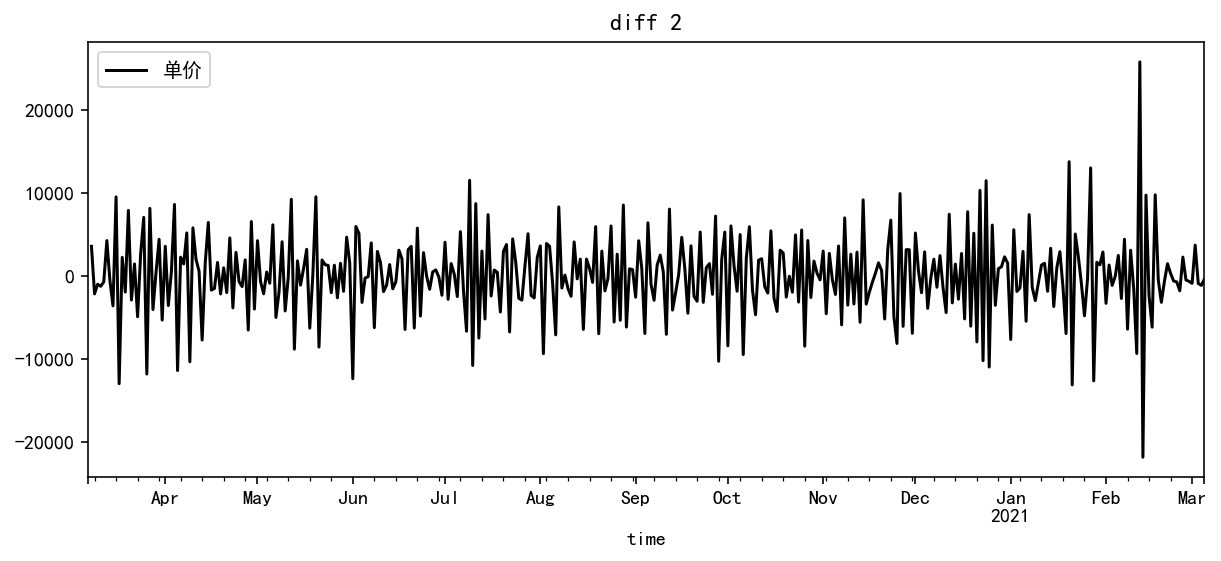

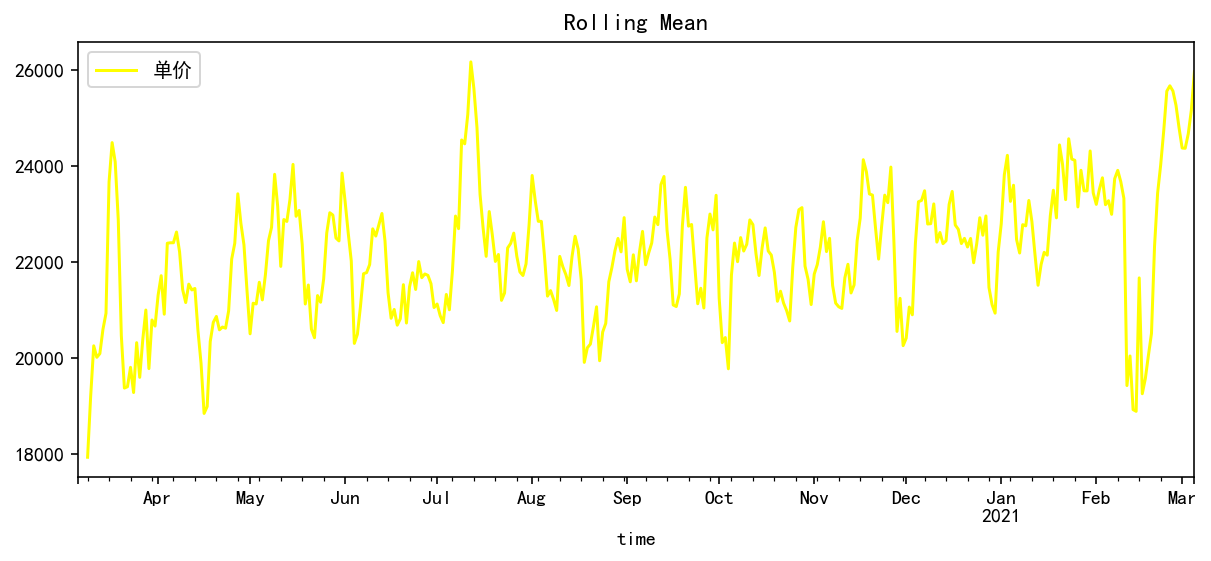

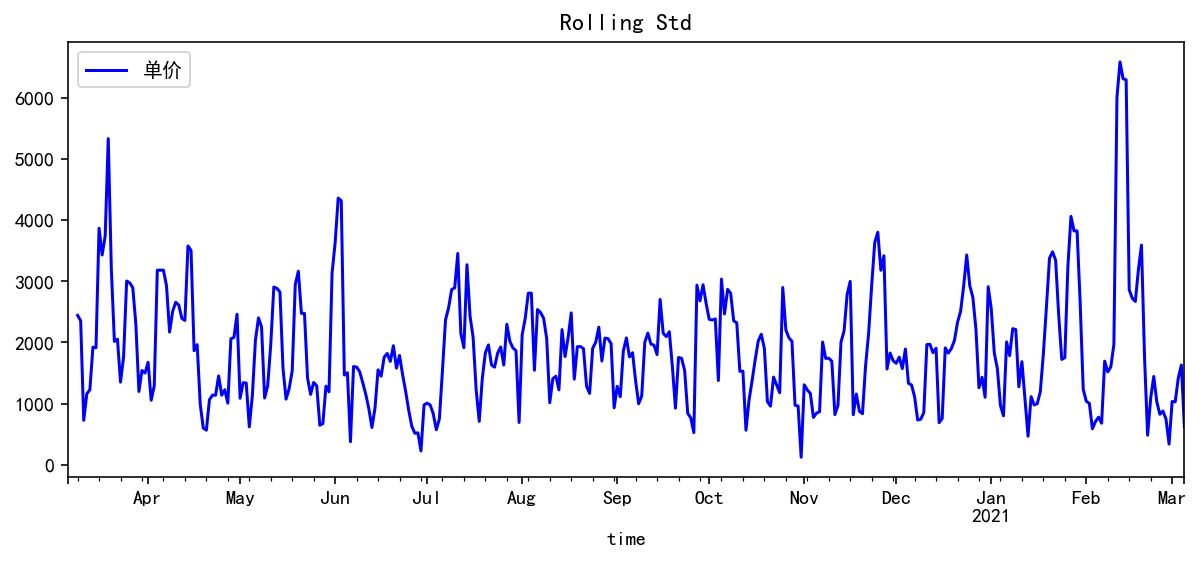

In [14]:
stationarity(data_train)
'''
ADT检验
 (1) 1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设，本数据中，adf结果为-6.9， 小于三个level的统计值。

（2）P-value是否非常接近0.本数据中，P-value 为 6.21e-23，接近0。
ADT检验结果说明数据平稳

非白噪声检验

统计量的P值约为0.0085，小于显著性水平0.05，则可以以95%的置信水平拒绝原假设，认为序列为非白噪声序列（否则，接受原假设，认为序列为纯随机序列。）  

'''

In [15]:
def tsplot(y, lags = None, title = '', figsize = (14,8)):
    fig = plt.figure(figsize = figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout , (0,0))
    hist_ax = plt.subplot2grid(layout , (0,1))
    acf_ax = plt.subplot2grid(layout , (1,0))
    pacf_ax = plt.subplot2grid(layout , (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax = hist_ax, kind = 'hist', bins = 25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags = lags, ax = acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x1f568023c70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f5681a8d30>)

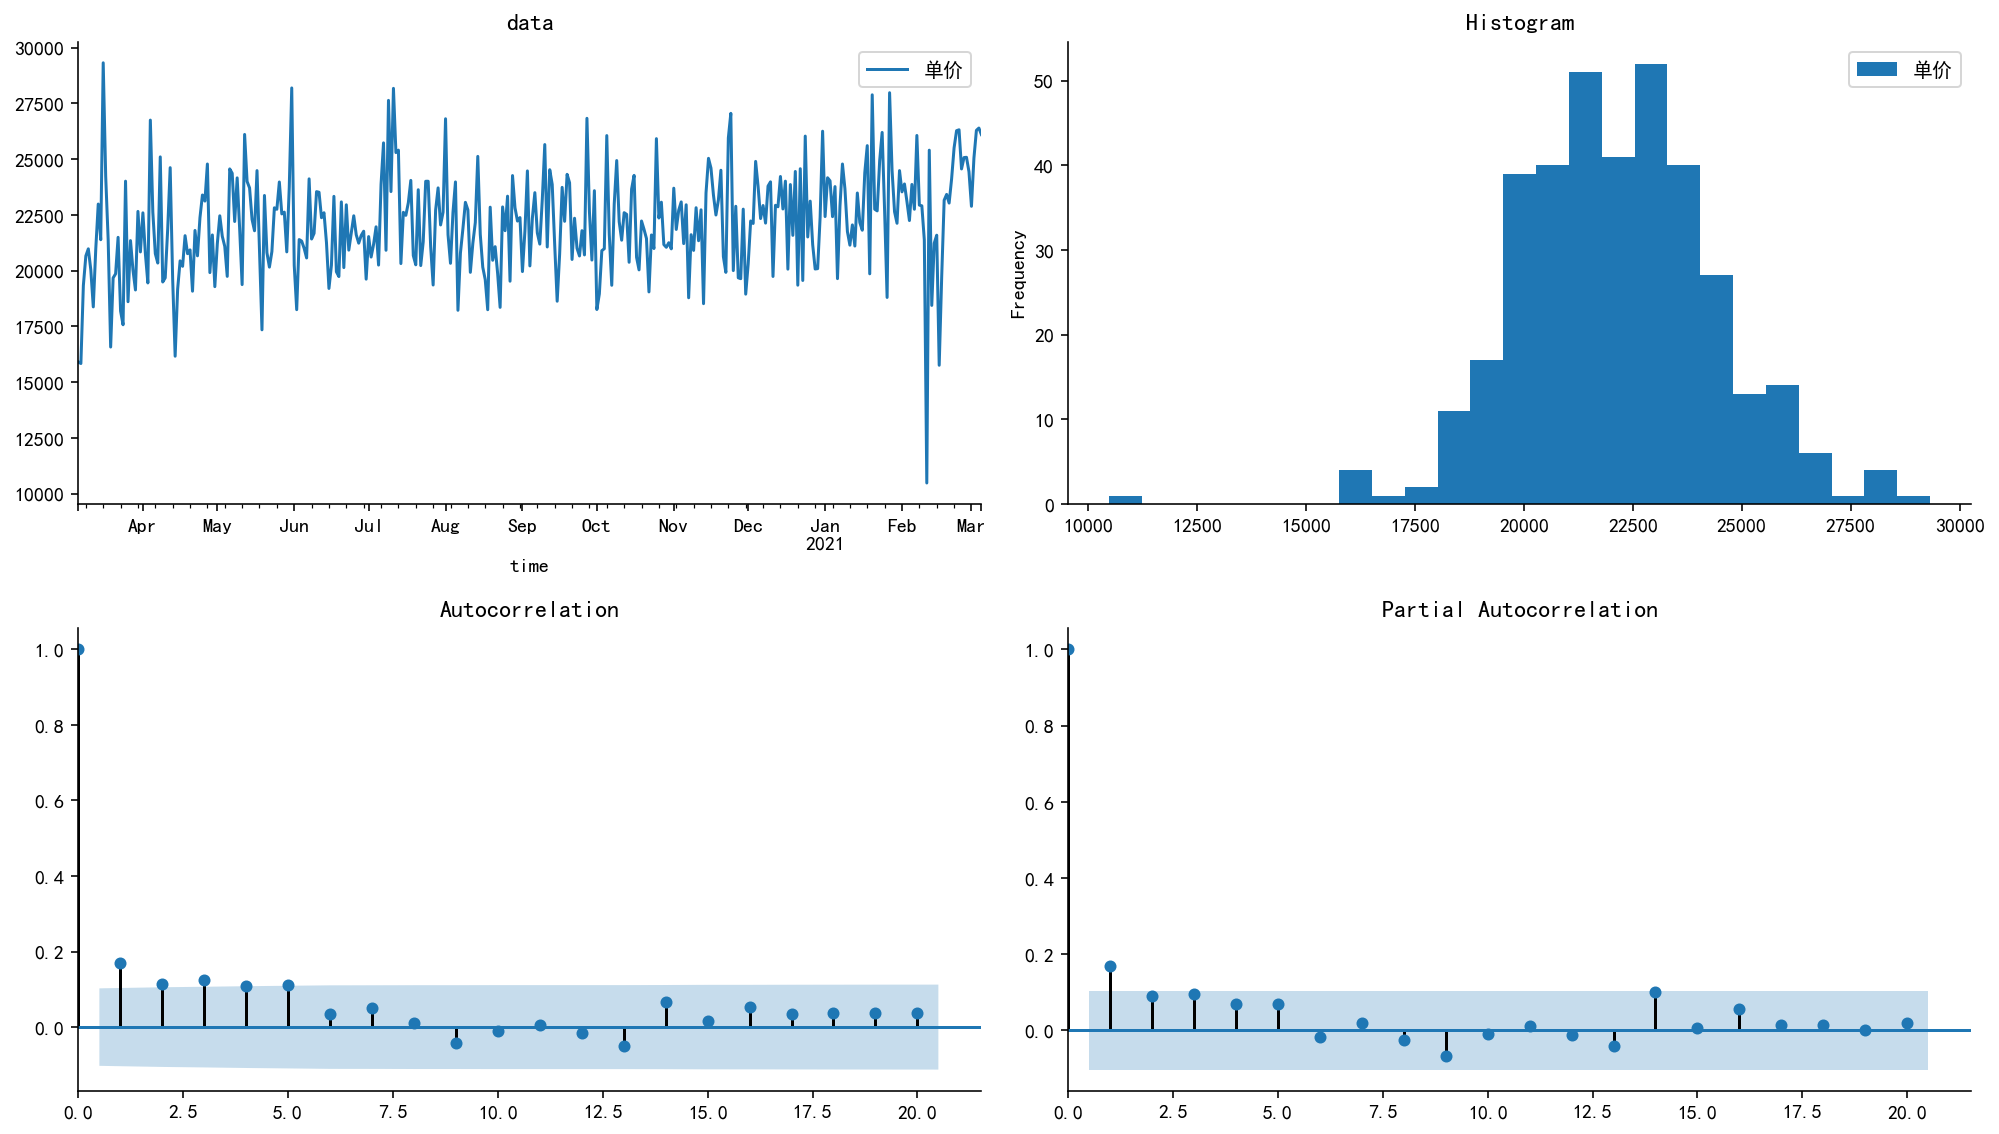

In [16]:
tsplot(data_train, title = 'data', lags = 20)

In [17]:
arima200 = sm.tsa.SARIMAX(data_train, order = (2,0,0))
model_results = arima200.fit()


F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [18]:
import itertools

p_min = 0
d_min = 1
q_min = 0
p_max = 6
d_max = 1
q_max = 3

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(
    index=['AR{}'.format(i) for i in range(p_min, p_max + 1)],
    columns=['MA{}'.format(i) for i in range(q_min, q_max + 1)])

for p, d, q in itertools.product(
        range(p_min, p_max + 1), range(d_min, d_max + 1),
        range(q_min, q_max + 1)):
    if p == 0 and d == 0 and q == 0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue

    try:
        model = sm.tsa.SARIMAX(
            data_train,
            order=(p, d, q),
            #enforce_stationarity=False,
            #enforce_invertibility=False,
        )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)


F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warni

F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warni

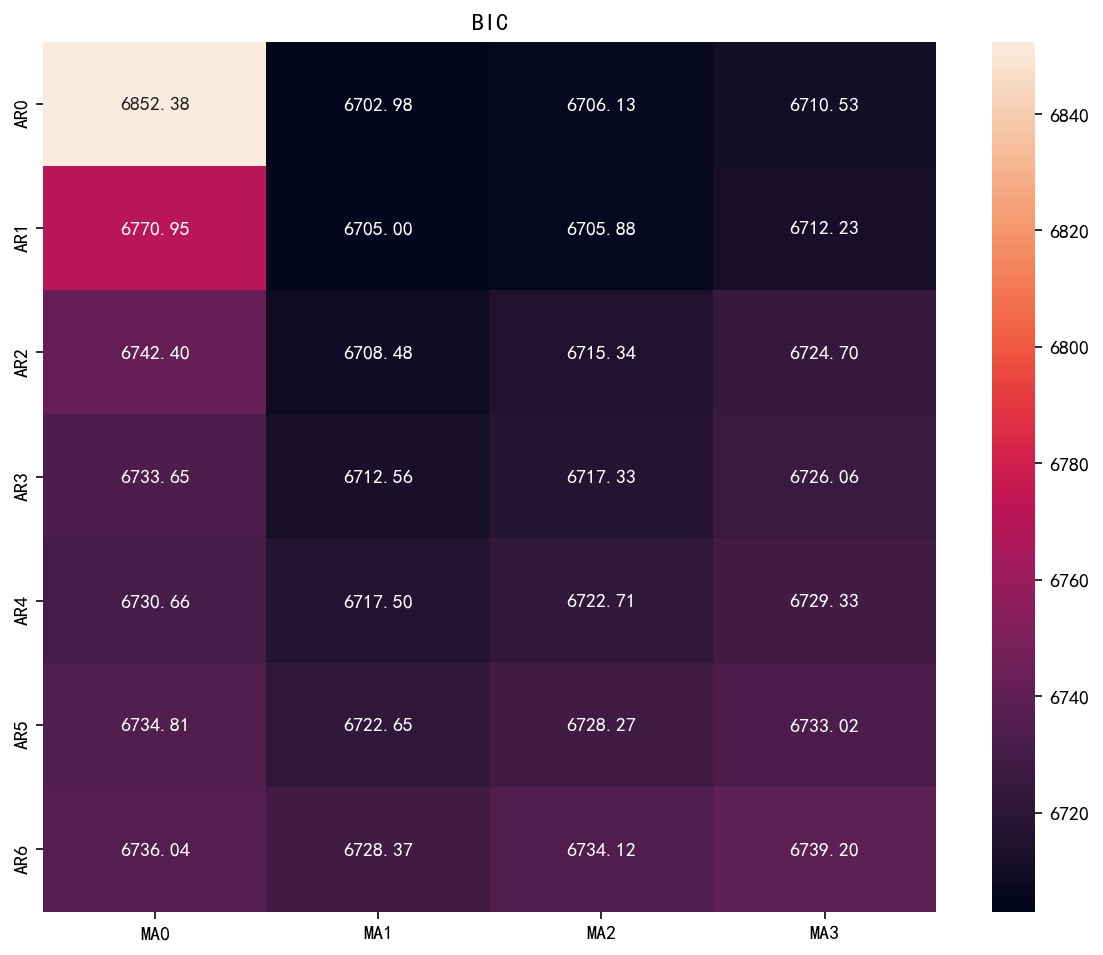

In [19]:
#模型选择bic:贝叶斯信息准则：选择最小的值

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');


In [20]:
data_diff = data_train.diff()
data_diff = data_diff.dropna()

In [21]:


train_results = sm.tsa.arma_order_select_ic(
    data_diff, ic=['aic', 'bic'], trend='nc', max_ar=6, max_ma=3)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)


F:\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
F:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
F:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
F:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
F:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
F:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: R

AIC (4, 3)
BIC (0, 1)


In [22]:
model = ARIMA(data_train, order = (0,1,1))


F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [23]:
result = model.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.单价   No. Observations:                  364
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3324.956
Method:                       css-mle   S.D. of innovations           2233.151
Date:                Sun, 21 Mar 2021   AIC                           6655.912
Time:                        08:20:33   BIC                           6667.604
Sample:                    03-07-2020   HQIC                          6660.559
                         - 03-05-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9916      3.894      1.796      0.073      -0.640      14.623
ma.L1.D.单价    -0.9793      0.028    -35.564      0.000      -1.033      -0.925
                                    Roots           

F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<Figure size 864x576 with 0 Axes>

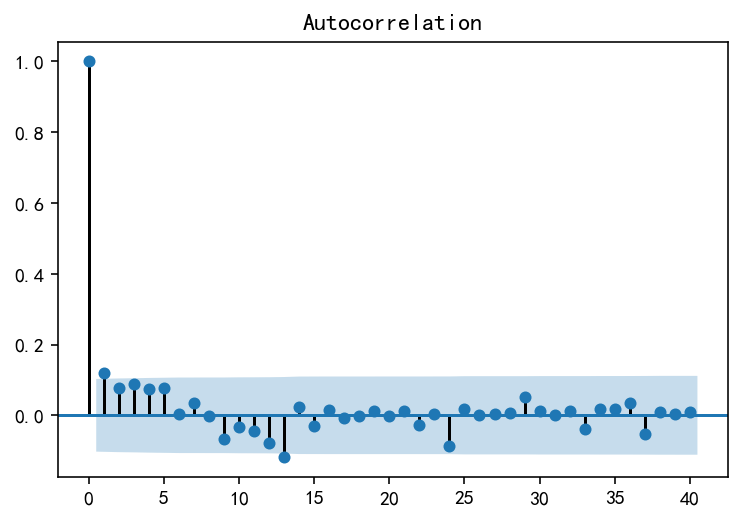

In [24]:
#模型自回归残差检验
model = sm.tsa.ARIMA(data_train, order=(0, 1, 1))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40)
plt.show()

In [35]:
#pred = result.predict('20210305','20210309',dynamic = True)
pred = result.predict('20200601','20210308',dynamic = True,typ = 'levels')
pred

2020-06-01    21993.017407
2020-06-02    22000.008960
2020-06-03    22007.000513
2020-06-04    22013.992066
2020-06-05    22020.983619
                  ...     
2021-03-04    23922.686067
2021-03-05    23929.677620
2021-03-06    23936.669173
2021-03-07    23943.660726
2021-03-08    23950.652279
Freq: D, Length: 281, dtype: float64

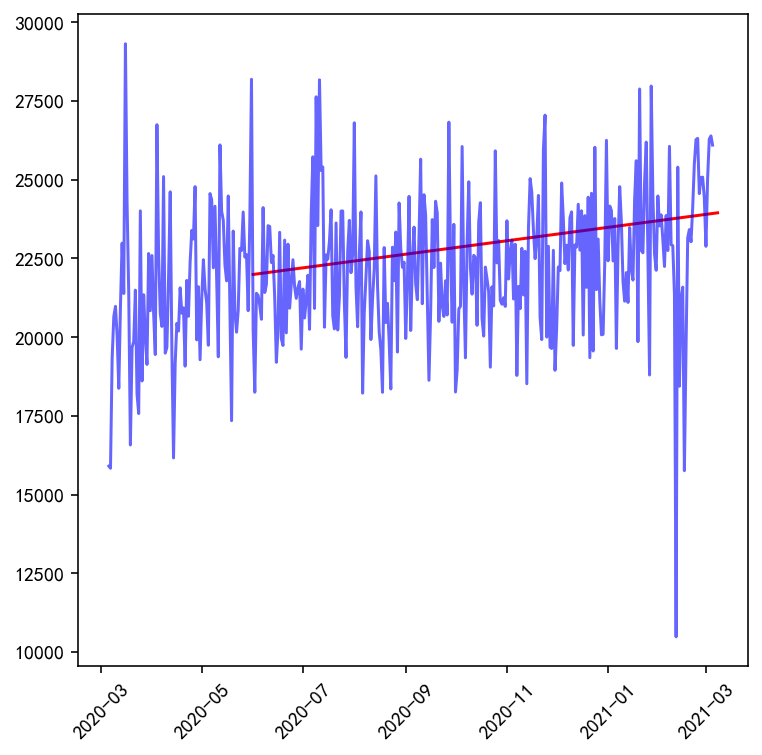

In [36]:
plt.figure(figsize=(6, 6))
plt.xticks(rotation=45)
plt.plot(pred,color = 'red')
plt.plot(data_train, color = 'blue',alpha = 0.6)

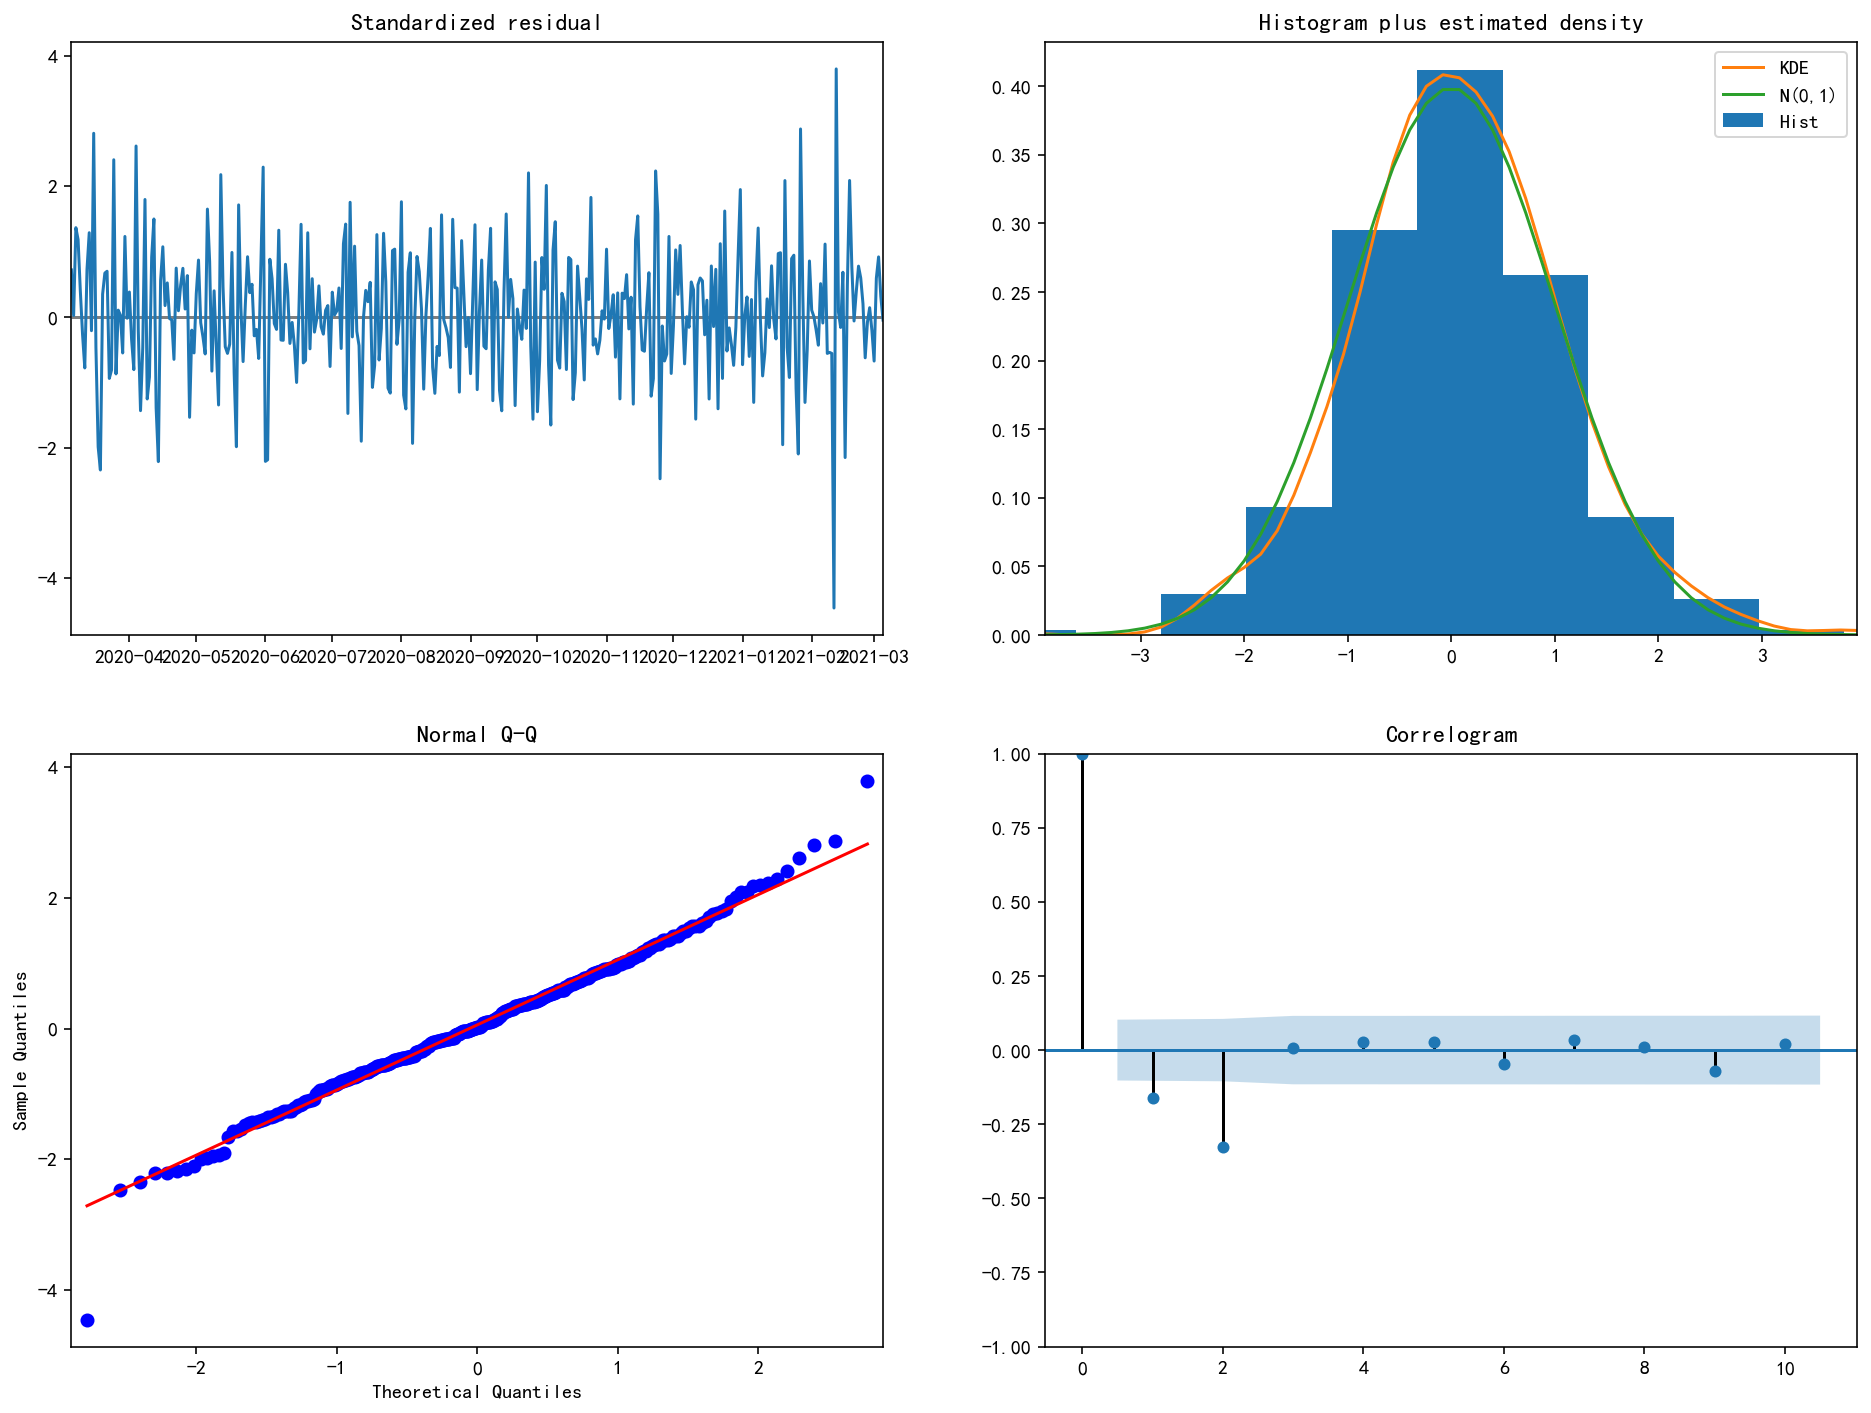

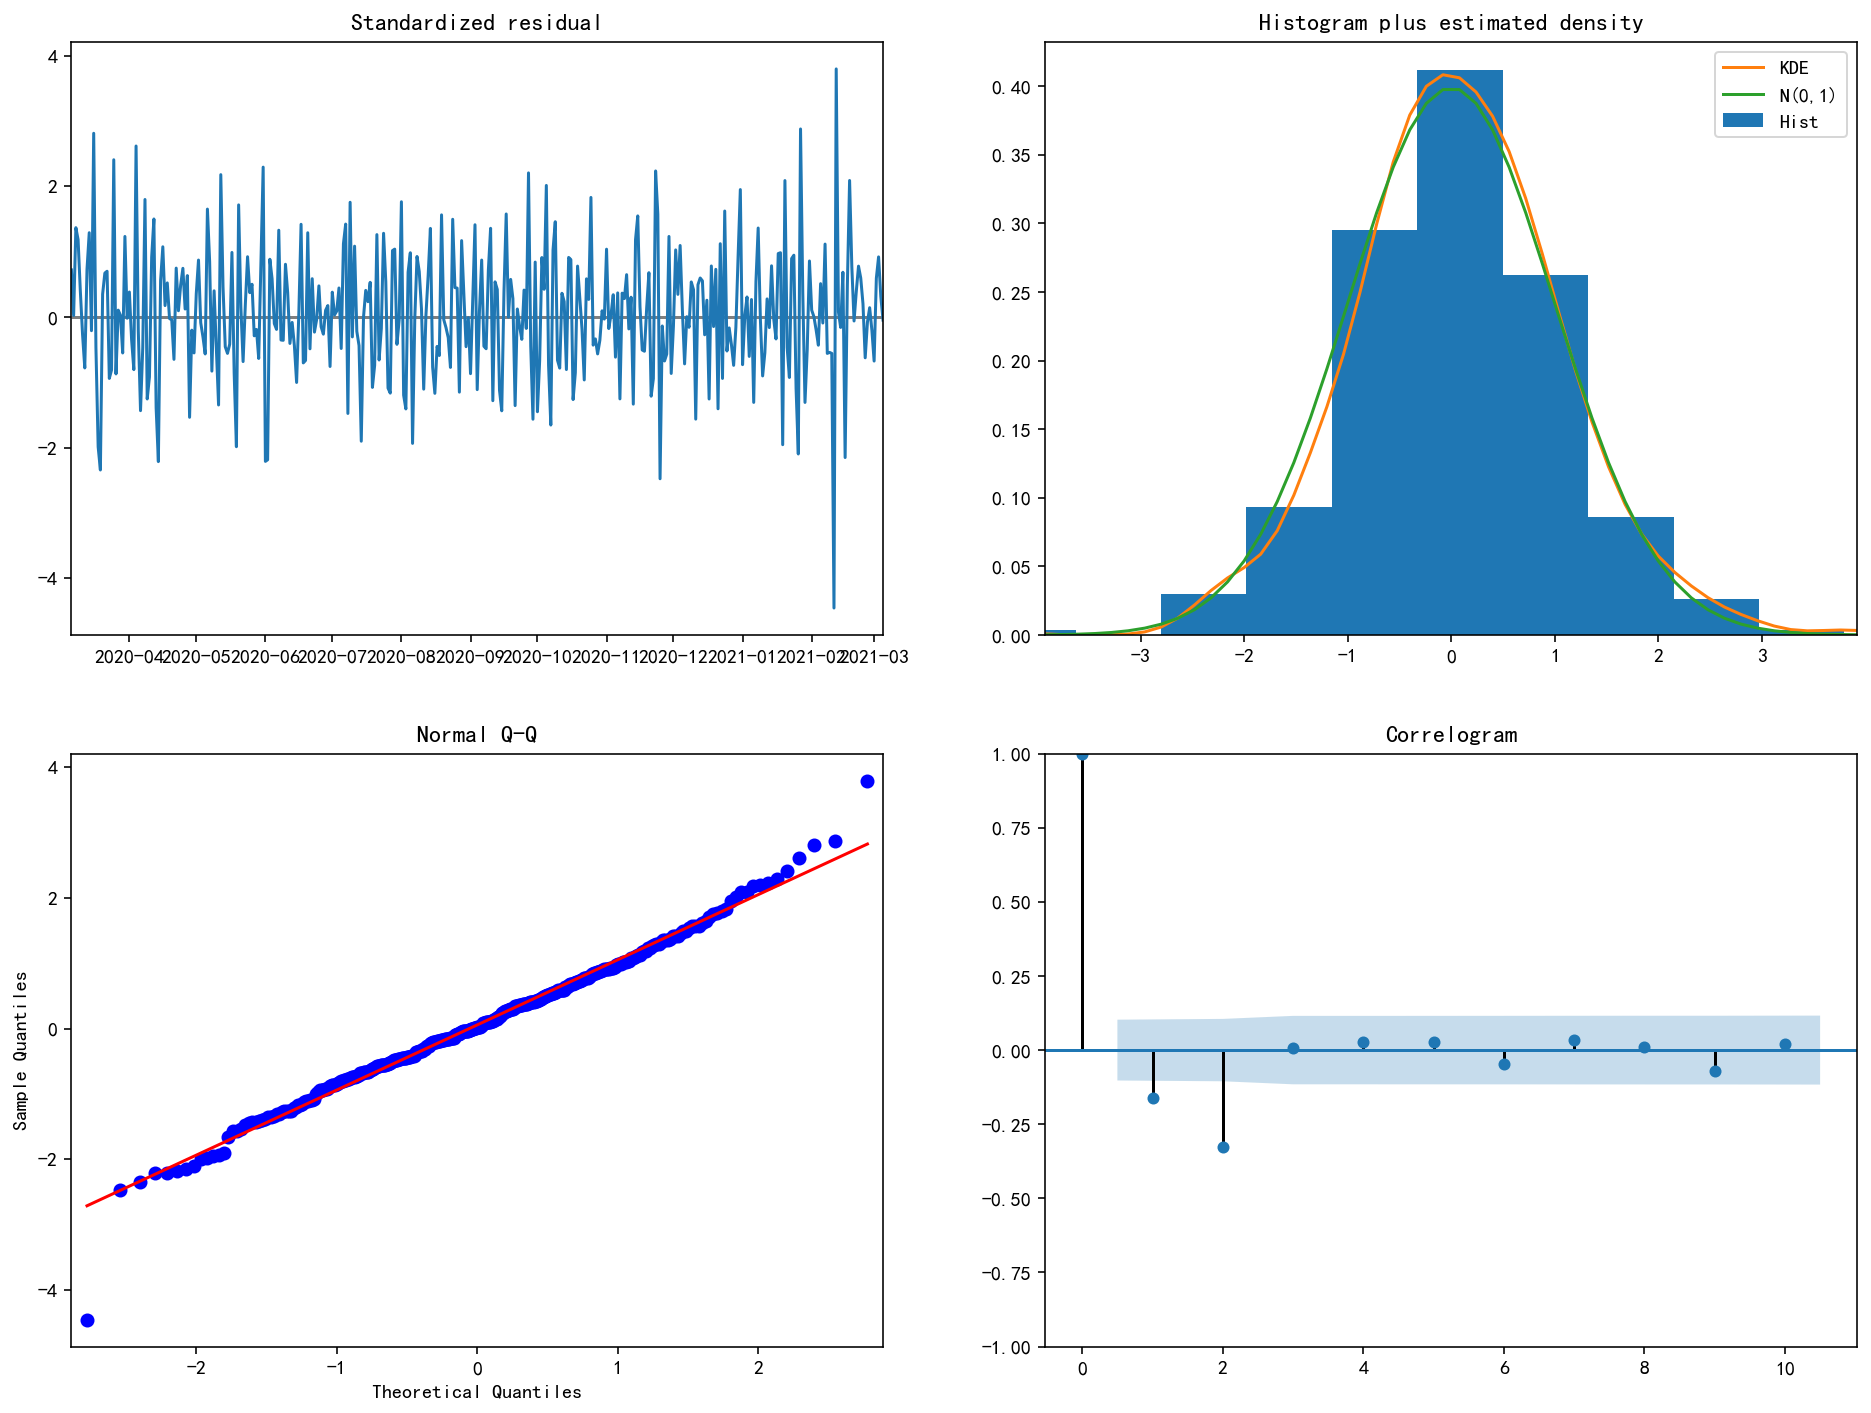

In [31]:
model_results.plot_diagnostics(figsize = (16,12))

In [28]:
data_test


,单价
time,
2021-03-06,26492.209677
2021-03-07,28569.045455


In [81]:
data_train.tail(20)

,单价
time,
2021-02-14,21232.428571
2021-02-15,21590.375000
2021-02-16,15759.200000
2021-02-17,19707.313725
2021-02-18,23158.534884
2021-02-19,23418.296820
2021-02-20,23030.599291
2021-02-21,24113.855219
2021-02-22,25505.750000


In [79]:
pred.tail(3)

2021-03-05    23060.216270
2021-03-06    23067.207823
2021-03-07    23074.199376
Freq: D, dtype: float64